In [1]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns
from collections import defaultdict
import os
import statsmodels.api as sm
from yfinance import download

sns.set_theme(style="whitegrid", context="paper")
sns.set_palette("coolwarm")
rs = check_random_state(42)

In [2]:
data_fama_french = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3)
data_fama_french_momentum = pd.read_csv("data/F-F_Momentum_Factor.CSV", skiprows=13)
data_fama_french_industry_portfolios = pd.read_csv(
    "data/10_Industry_Portfolios.CSV", skiprows=11
)  # value weighted
data_fama_french_100_portfolios = pd.read_csv(
    "data/100_Portfolios_10x10.CSV", skiprows=15
)  # value weighted

fred_recessions = pd.read_csv("data/fred_recession_cycles.csv")

# data_fama_french_daily = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=3)
# data_stocks = pd.read_csv("data/characteristics_data_feb2017.csv")

In [3]:
data_fama_french["Date"] = pd.to_datetime(data_fama_french["Date"], format="%Y%m")
data_fama_french = data_fama_french.set_index("Date")

data_fama_french_momentum["Date"] = pd.to_datetime(
    data_fama_french_momentum["Date"], format="%Y%m"
)
data_fama_french_momentum = data_fama_french_momentum.set_index("Date")

data_fama_french_industry_portfolios["Date"] = pd.to_datetime(
    data_fama_french_industry_portfolios["Date"], format="%Y%m"
)
data_fama_french_industry_portfolios = data_fama_french_industry_portfolios.set_index(
    "Date"
)

data_fama_french_100_portfolios["Date"] = pd.to_datetime(
    data_fama_french_100_portfolios["Date"], format="%Y%m"
)
data_fama_french_100_portfolios = data_fama_french_100_portfolios.set_index(
    "Date"
)
data_fama_french_100_portfolios = data_fama_french_100_portfolios.loc[data_fama_french.index[0]:]

fred_recessions["Peak"] = pd.to_datetime(fred_recessions["Peak"], format="%Y-%m-%d")
fred_recessions["Trough"] = pd.to_datetime(fred_recessions["Trough"], format="%Y-%m-%d")

# data_fama_french_daily["Date"] = pd.to_datetime(data_fama_french_daily["Date"], format="%Y%m%d")
# data_fama_french_daily = data_fama_french_daily.set_index("Date")


# data_fama_french[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] /= 100
# leaving the data in percentage format to reduce float precision errors

In [4]:
def plot_cumulative_returns(returns, title="Cumulative Returns"):
    cumulative = (1 + returns).cumprod()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=cumulative, linewidth=2, palette="gist_earth" if cumulative.ndim == 2 else None)
    plt.title(title)
    plt.xlabel("Date" if isinstance(cumulative.index, pd.DatetimeIndex) else "Period")
    plt.ylabel("Cumulative Return")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

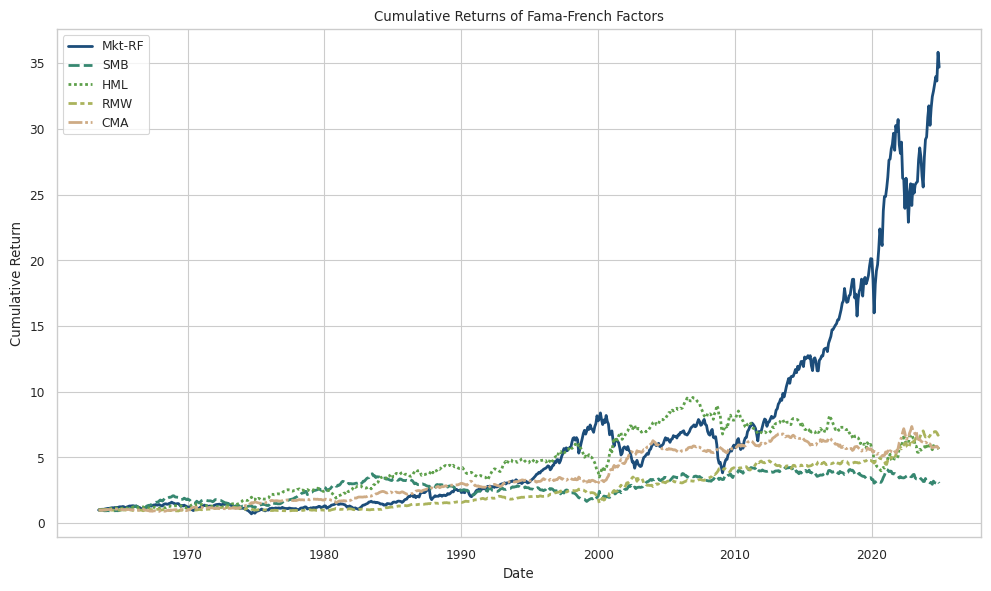

In [5]:
plot_cumulative_returns(
    data_fama_french[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]] / 100,
    title="Cumulative Returns of Fama-French Factors",
)

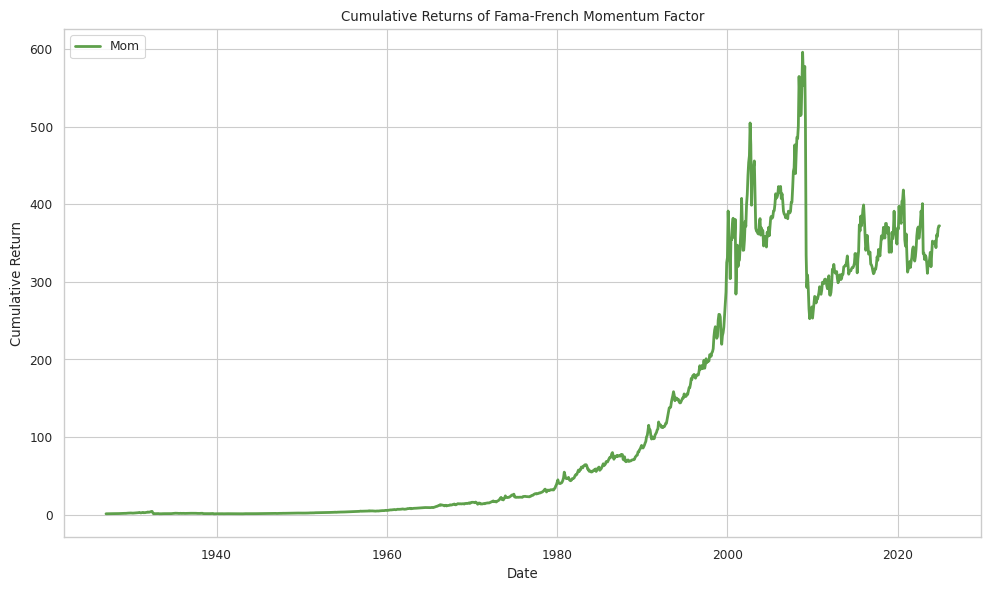

In [6]:
plot_cumulative_returns(
    data_fama_french_momentum[["Mom"]] / 100,
    title="Cumulative Returns of Fama-French Momentum Factor",
)

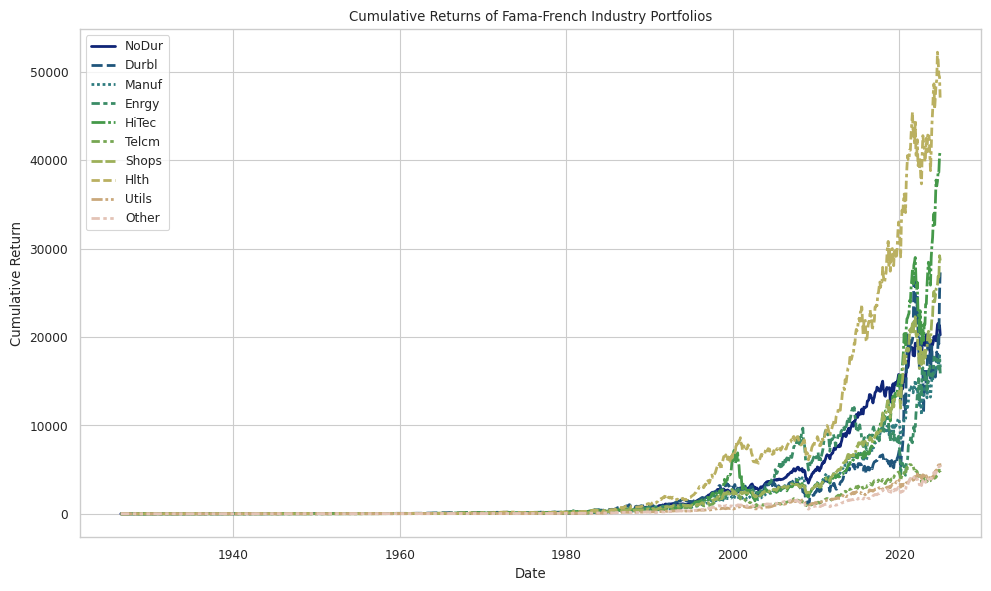

In [7]:
plot_cumulative_returns(
    data_fama_french_industry_portfolios[
        [
            "NoDur",
            "Durbl",
            "Manuf",
            "Enrgy",
            "HiTec",
            "Telcm",
            "Shops",
            "Hlth",
            "Utils",
            "Other",
        ]
    ]
    / 100,
    title="Cumulative Returns of Fama-French Industry Portfolios",
)

Nauči model na svih 6 parametara iz Fama-French podataka po cijeloj povijesti.
Vidi jesu li bolja 2, 3 ili 4 stanja
Full covar
GaussianHMM

In [8]:
model_parameters_df = pd.concat(
    [data_fama_french, data_fama_french_momentum, data_fama_french_industry_portfolios],
    axis=1,
).dropna()
model_parameters_df

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,,,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.90,-0.48,-0.07,-1.39,2.30,-0.68,-0.25,-1.05,0.57,0.81,-1.59
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01,4.87,6.54,6.19,3.94,5.13,4.28,6.42,9.56,4.20,5.44
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19,-1.69,-0.25,-0.78,-3.65,0.14,2.36,0.93,-4.07,-2.50,-3.18
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12,2.66,10.71,2.54,-0.33,8.30,3.43,0.51,3.38,-0.67,1.39
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74,-1.12,-5.17,0.30,-1.15,-0.29,4.14,-1.25,-1.65,-1.02,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79,4.11,-5.16,1.79,-2.92,1.35,1.21,1.35,6.44,4.55,3.03
2024-09-01,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60,0.99,14.24,2.83,-3.17,2.96,5.63,3.67,-1.81,5.35,0.66
2024-10-01,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87,-2.59,-3.14,-3.60,-0.54,-0.21,2.36,-1.14,-3.11,0.71,1.11


In [9]:
# X = data_fama_french.values.reshape(-1, 1)
# lengths = [len(data_fama_french)] * 6

# X_daily = data_fama_french_daily.values
# lengths_daily = [len(data_fama_french_daily)]

In [10]:
# TODO add K-means initialization


def evaluate_hmm(model_parameters_df, rs, ns, loop):
    aic = []
    bic = []
    lls = []
    convergence_status = []
    iterations = []
    # ns = [2, 3, 4, 5]
    models = defaultdict(list)
    # save in this format: {number_of_states: [(model, LL), ...]}
    best_models = defaultdict()

    X = model_parameters_df.values
    lengths = [len(X)]

    for n in ns:
        best_ll = None
        best_model = None
        for _ in range(loop):
            h = GaussianHMM(
                n,
                n_iter=2000,
                tol=1e-6,
                random_state=rs,
                covariance_type="full",
                verbose=False,
            )
            h.fit(X, lengths)
            score = h.score(X, lengths)
            models[n].append((h, score))
            if not best_ll or best_ll < score:
                best_ll = score
                best_model = h

        best_models[n] = best_model
        aic.append(best_model.aic(X))
        bic.append(best_model.bic(X))
        lls.append(best_model.score(X))
        convergence_status.append(best_model.monitor_.converged)
        iterations.append(best_model.monitor_.iter)

    print("Convergence Status: ", convergence_status)
    print("Iterations: ", iterations)
    return aic, bic, lls, convergence_status, iterations, best_models, models

In [11]:
def plot_selection(ns, aic, bic, lls):
    fig, ax = plt.subplots()
    ax.plot(ns, aic, label="AIC", color="blue", marker="o")
    ax.plot(ns, bic, label="BIC", color="green", marker="o")
    ax2 = ax.twinx()
    ax2.plot(ns, lls, label="LL", color="orange", marker="o")
    ax.legend(handles=ax.lines + ax2.lines)
    ax.set_title("Using AIC/BIC for Model Selection")
    ax.set_ylabel("Criterion Value (lower is better)")
    ax2.set_ylabel("LL (higher is better)")
    ax.set_xlabel("Number of HMM Components")
    fig.tight_layout()
    plt.show()


# TODO add heuristic to choose optimal number of components, currently visually finding the elbow

In [12]:
def plot_ll_histograms(models):
    ns = sorted(models.keys())
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for idx, n_components in enumerate(ns):
        component_scores = [score for (_, score) in models[n_components]]

        axes[idx].hist(
            component_scores, bins=25, edgecolor="k", alpha=0.65, density=True
        )

        axes[idx].set_title(
            f"{n_components}-State HMM\n(n={len(component_scores)})", pad=12
        )
        axes[idx].set_xlabel("Log-Likelihood", labelpad=8)
        axes[idx].set_ylabel("Density", labelpad=8)
        axes[idx].grid(True, linestyle="--", alpha=0.6)

        mean_ll = np.mean(component_scores)
        axes[idx].axvline(
            mean_ll,
            color="r",
            linestyle="--",
            linewidth=1.5,
            label=f"Mean: {mean_ll:.1f}",
        )
        axes[idx].legend()

    plt.tight_layout(pad=2.0)
    plt.show()

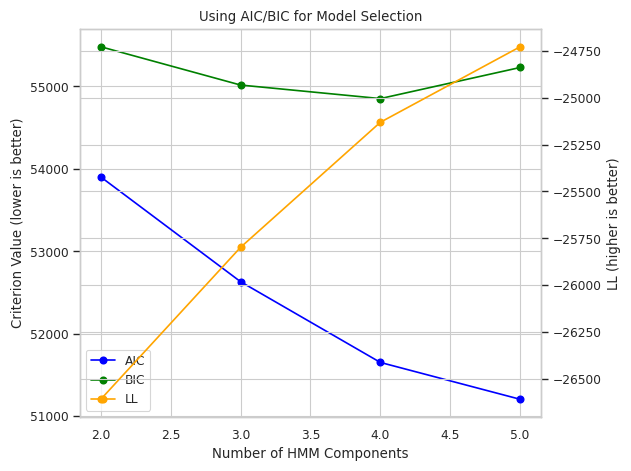

In [13]:
%%capture --no-display

aic, bic, lls, convergence_status, iterations, best_models, models = evaluate_hmm(
    model_parameters_df, rs, [2, 3, 4, 5], loop=200
)
plot_selection([2, 3, 4, 5], aic, bic, lls)

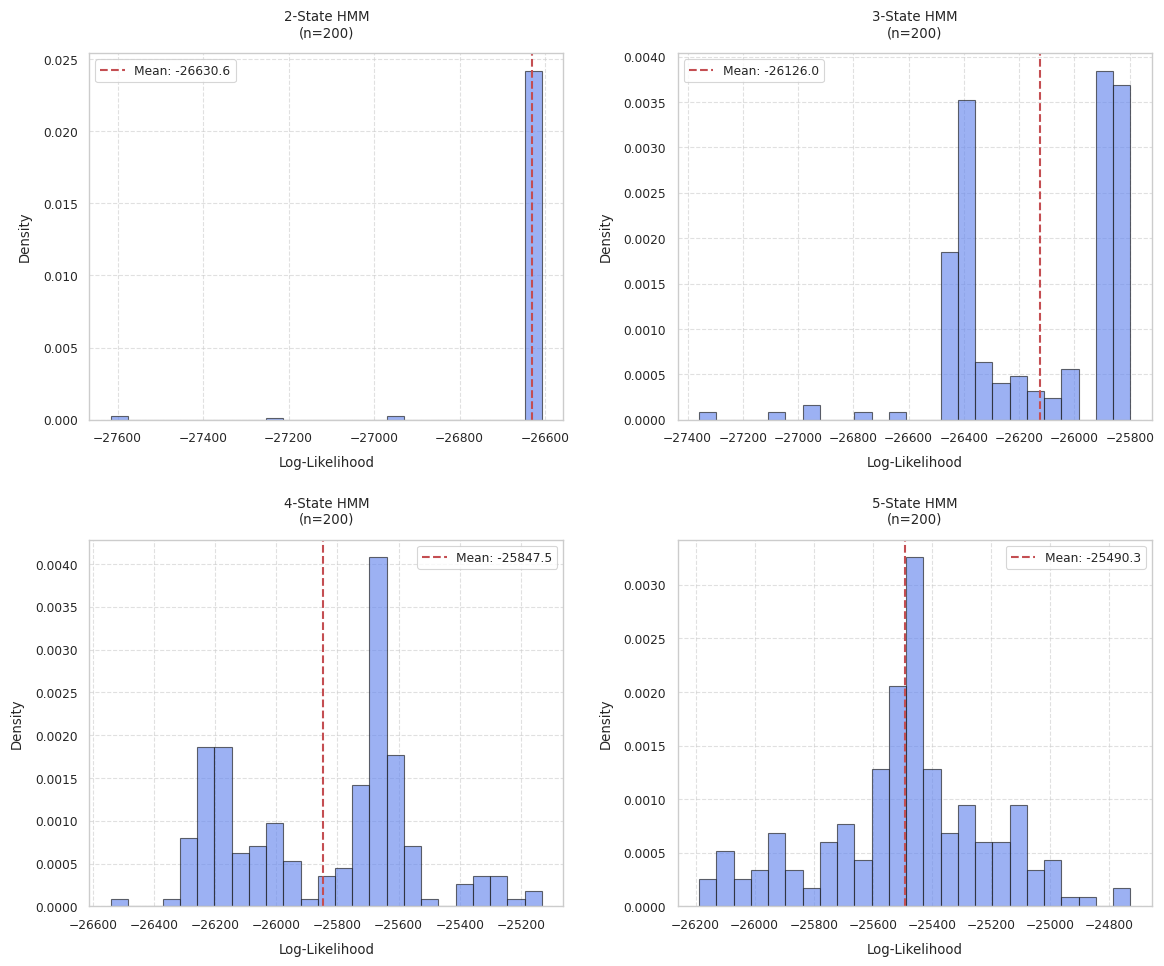

In [14]:
plot_ll_histograms(models)

Provedimo detaljnu analizu za modele s 2, 3 i 4 stanja. Grafovi će biti spremljeni u poseban direktorij.

In [15]:
h = best_models[4]
X = model_parameters_df.values
lengths = [len(X)]
hidden_states = h.predict(X, lengths=lengths)

model_2_states = best_models[2]

model_3_states = best_models[3]

In [16]:
state_probs_2 = model_2_states.predict_proba(X, lengths=len(X))
state_probs_3 = model_3_states.predict_proba(X, lengths=len(X))
state_probs_4 = h.predict_proba(X, lengths=len(X))

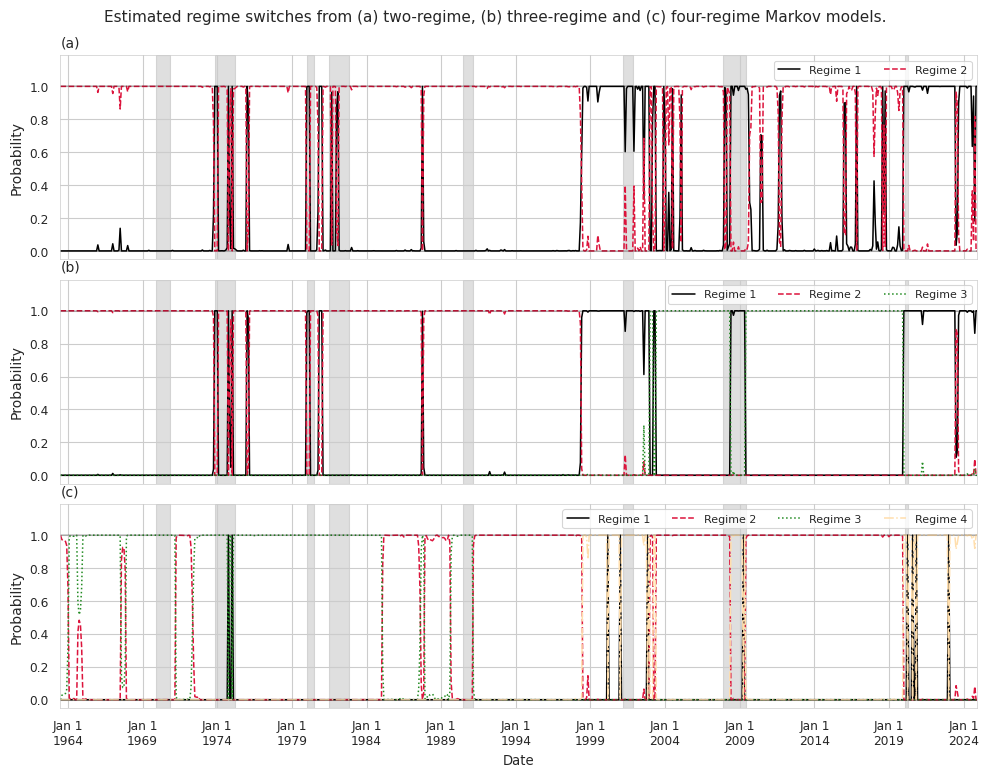

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
fig.text(
    0.5,
    0.95,
    "Estimated regime switches from (a) two-regime, (b) three-regime and (c) four-regime Markov models.",
    ha="center",
    fontsize=11,
)

line_styles = ["-", "--", ":", "-."]
colors = ["black", "crimson", "forestgreen", "navajowhite"]

titles = ["(a)", "(b)", "(c)"]
probs = [state_probs_2, state_probs_3, state_probs_4]
n_regimes = [2, 3, 4]

for i, (ax, prob, n_regime) in enumerate(zip(axes, probs, n_regimes)):
    ax.set_title(titles[i], loc="left", fontsize=10)

    for j in range(n_regime):
        sns.lineplot(
            x=model_parameters_df.index,
            y=prob[:, j],
            ax=ax,
            linestyle=line_styles[j % len(line_styles)],
            color=colors[j % len(colors)],
            linewidth=1.1,
            label=f"Regime {j+1}",
        )

    ax.legend(loc="upper right", ncol=n_regime, frameon=True, fontsize="small")

    ax.set_ylim(-0.05, 1.19)
    ax.set_ylabel("Probability", fontsize=10)

    ax.set_xlim(model_parameters_df.index[0], model_parameters_df.index[-1])

    ax.axhline(y=0, color="black", linestyle="-", alpha=0.2)
    ax.axhline(y=1, color="black", linestyle="-", alpha=0.2)

    for _, row in fred_recessions.iterrows():
        ax.axvspan(row["Peak"], row["Trough"], color="gray", alpha=0.25, zorder=0)

year_ticks = pd.date_range(
    start=model_parameters_df.index[0], end=model_parameters_df.index[-1], freq="5YS"
)
axes[2].set_xticks(year_ticks)
axes[2].set_xticklabels([f"Jan 1\n{date.year}" for date in year_ticks])

sns.despine()

for ax in axes:
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["top"].set_linewidth(0.5)
    ax.spines["right"].set_linewidth(0.5)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.1)
plt.show()

In [18]:
def plot_means_by_state(h, model_parameters_df):
    means = h.means_
    n_components = h.n_components
    feature_names = model_parameters_df.columns
    n_features = len(feature_names)

    data_list = []
    for i in range(n_components):
        for j in range(n_features):
            data_list.append(
                {
                    "Hidden State": f"State {i}",
                    "Feature": feature_names[j],
                    "Mean": means[i, j],
                }
            )
    means_df = pd.DataFrame(data_list)

    y_min = means_df["Mean"].min()
    y_max = means_df["Mean"].max()

    aspect_ratio = 1.5
    base_fontsize = 10
    fontsize = max(6, base_fontsize - n_features / (5 * aspect_ratio))

    g = sns.catplot(
        data=means_df,
        x="Feature",
        y="Mean",
        col="Hidden State",
        kind="bar",
        col_wrap=2,
        height=5,
        aspect=aspect_ratio,
        sharex=False,
        sharey=False,
        edgecolor="black",
    )

    g.set_titles("Hidden {col_name}")

    for ax in g.axes.flat:
        if not ax.has_data():
            continue
        ax.set_ylim(y_min - 0.1, y_max + 0.1)
        ax.set_xticks(np.arange(n_features))
        ax.set_xticklabels(feature_names, rotation=0, ha="center", fontsize=fontsize)

        ax.tick_params(axis="x", labelbottom=True)

        ax.grid(True, linestyle="--", alpha=0.7)

    g.set_axis_labels("Feature", "Mean Value")
    g.figure.suptitle("Mean Values per Hidden State", y=1.02, fontsize=16)

    g.figure.tight_layout(pad=2.0)

    return g

In [19]:
def plot_stdev_by_state(h, model_parameters_df):
    covars_raw = h.covars_
    feature_names = model_parameters_df.columns

    variances = np.diagonal(covars_raw, axis1=1, axis2=2)

    stdevs = np.sqrt(np.maximum(variances, 0))
    n_components, n_features = stdevs.shape

    stdev_df = pd.DataFrame(
        {
            "Hidden State": np.repeat(
                [f"State {i}" for i in range(n_components)], n_features
            ),
            "Feature": np.tile(feature_names, n_components),
            "Stdev": stdevs.ravel(),
        }
    )

    y_min = stdev_df["Stdev"].min()
    y_max = stdev_df["Stdev"].max()

    aspect_ratio = 1.5
    fontsize = max(6, 10 - n_features / (7.5))

    g = sns.catplot(
        data=stdev_df,
        x="Feature",
        y="Stdev",
        col="Hidden State",
        kind="bar",
        col_wrap=2,
        height=5,
        aspect=aspect_ratio,
        sharex=False,
        sharey=False,
        edgecolor="black",
    )

    g.set_titles("Hidden {col_name}")

    for i, ax in enumerate(g.axes.flat):
        if i < n_components:
            ax.set_xticks(np.arange(n_features))
            ax.set_xticklabels(
                feature_names, rotation=0, ha="center", fontsize=fontsize
            )
            ax.tick_params(axis="x", labelbottom=True)
            ax.grid(True, linestyle="--", alpha=0.7)
            ax.set_ylim(y_min - 0.1, y_max + 0.1)

    g.set_axis_labels("Feature", "Standard Deviation")
    g.figure.suptitle(
        "Feature Standard Deviations per Hidden State", y=1.02, fontsize=16
    )
    g.figure.tight_layout(pad=2.0)
    
    return g

In [20]:
def convert_to_correlation_matrix(covariance_matrix):

    d = np.sqrt(np.diag(covariance_matrix))
    correlation_matrix = covariance_matrix / np.outer(d, d)
    return correlation_matrix

In [21]:
def plot_correlation_heatmaps(correlation_matrices, factor_names):
    num_states = len(correlation_matrices)

    if num_states == 4:
        nrows, ncols = 2, 2
    elif num_states == 3:
        nrows, ncols = 1, 3
    elif num_states == 2:
        nrows, ncols = 1, 2
    else:
        nrows, ncols = 1, num_states

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)
    axes_flat = axes.flatten()

    plot_limit = num_states
    mask = np.triu(np.ones_like(correlation_matrices[0], dtype=bool))

    for i in range(plot_limit):
        ax = axes_flat[i]
        sns.heatmap(
            correlation_matrices[i],
            mask=mask,
            cmap="coolwarm",
            linewidths=0.5,
            ax=ax,
            xticklabels=factor_names,
            yticklabels=factor_names,
            vmin=-1,
            vmax=1,
            cbar=(i == ncols - 1) or (i == plot_limit - 1 and plot_limit % ncols != 0),
            cbar_kws={"label": "Correlation"}
            if (i == ncols - 1) or (i == plot_limit - 1 and plot_limit % ncols != 0)
            else {},
            square=True,
        )
        ax.set_title(f"State {i} Correlations")
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
        plt.setp(ax.get_yticklabels(), rotation=0, ha="right")


    for j in range(plot_limit, nrows * ncols):
        if j < len(axes_flat):
            fig.delaxes(axes_flat[j])

    fig.suptitle("Factor Correlation Matrices per Hidden State", fontsize=16, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig


In [22]:
def plot_transition_matrix(transmat, num_states):

    fig, ax = plt.subplots()
    sns.heatmap(
        transmat,
        annot=True,
        cmap="coolwarm",
        fmt=".3f",
        linewidths=0.5,
        ax=ax,
        xticklabels=[f"State {i}" for i in range(num_states)],
        yticklabels=[f"State {i}" for i in range(num_states)],
    )
    ax.set_title("Transition Matrix")
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    return fig

In [23]:
def plot_regime_probabilities(
    state_probs, 
    time_index, 
    n_regimes, 
    fred_recessions=None, 
    title="Estimated Regime Probabilities"
):
    line_styles = ["-", "--", ":", "-."]
    colors = ["black", "crimson", "forestgreen", "navajowhite"]
    
    plt.figure(figsize=(10, 3))
    for j in range(n_regimes):
        sns.lineplot(
            x=time_index,
            y=state_probs[:, j],
            linestyle=line_styles[j % len(line_styles)],
            color=colors[j % len(colors)],
            linewidth=1.1,
            label=f"Regime {j+1}",
        )
    plt.ylim(-0.05, 1.19)
    plt.ylabel("Probability", fontsize=10)
    plt.xlim(time_index[0], time_index[-1])
    plt.axhline(y=0, color="black", linestyle="-", alpha=0.2)
    plt.axhline(y=1, color="black", linestyle="-", alpha=0.2)
    if fred_recessions is not None:
        for _, row in fred_recessions.iterrows():
            plt.axvspan(row["Peak"], row["Trough"], color="gray", alpha=0.25, zorder=0)
    plt.legend(loc="upper right", ncol=n_regimes, frameon=True, fontsize="small")
    plt.title(title, fontsize=11)
    sns.despine()
    plt.tight_layout()
    return plt.gcf()

In [24]:
def run_model_analysis(model, model_parameters_df, dirname, fred_recessions, state_probs):
    num_states = model.n_components
    dir = f"figures/{dirname}/{num_states}_states/"
    if not os.path.exists(dir):
        os.makedirs(dir)

    fig1 = plot_means_by_state(model, model_parameters_df)
    fig1.savefig(os.path.join(dir, "means_by_state.png"), dpi=300)
    plt.close(fig1.figure)

    fig2 = plot_stdev_by_state(model, model_parameters_df)
    fig2.savefig(os.path.join(dir, "stdev_by_state.png"), dpi=300)
    plt.close(fig2.figure)

    covariance_matrices = model.covars_
    correlation_matrices = []
    for matrix in covariance_matrices:
        correlation_matrix = convert_to_correlation_matrix(matrix)
        correlation_matrices.append(correlation_matrix)
    factor_names = model_parameters_df.columns.tolist()

    fig3 = plot_correlation_heatmaps(correlation_matrices, factor_names)
    fig3.savefig(os.path.join(dir, "correlation_heatmaps.png"), dpi=300)
    plt.close(fig3)

    fig4 = plot_transition_matrix(model.transmat_, num_states)
    fig4.savefig(os.path.join(dir, "transition_matrix.png"), dpi=300)
    plt.close(fig4)

    fig5 = plot_regime_probabilities(
        state_probs,
        model_parameters_df.index,
        num_states,
        fred_recessions,
        title=f"Estimated Regime Probabilities for {num_states} States",
    )
    fig5.savefig(os.path.join(dir, "regime_probabilities.png"), dpi=300)
    plt.close(fig5)

    return "Successfully saved figures to directory:", dir


In [25]:
for i,j in [(2, state_probs_2), (3, state_probs_3), (4, state_probs_4)]:
    run_model_analysis(best_models[i], model_parameters_df, dirname="state_analysis_full_timeframe", fred_recessions=fred_recessions, state_probs=j)

Iako model s 4 stanja ima najbolji AIC/BIC/LL score, analizom grafova koji predstavljaju model s 4 stanja naslućujemo da su 4 stanja previše i da su neka redundantna.
Pogledajmo grafove standardnih devijacija i očekivanih vrijednosti. Vidimo da su stanja 1 i dva gotovo ista po svim značajkama.
Pogledajmo nadalje matricu tranzicija, vidimo da postoji stanje koje nikada ne ostaje u samome sebi, tranizicjsko stanje u kojem je model najduže jedan trenutak, ovo nam govori da je vjerojatno redundantno za model.

Zbog navedenih razloga nastaviti ćemo s modelom s 2 stanja.

In [26]:
def run_weighted_ff_regressions(
    data_fama_french_100_portfolios,
    model_parameters_df,
    state_probs
):
    excess_returns = data_fama_french_100_portfolios - model_parameters_df["RF"].values.reshape(-1, 1)
    columns = ["Alpha", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "R^2", "Std(e)"]
    results = [pd.DataFrame(index=excess_returns.columns, columns=columns) for _ in range(2)]

    for state in [0, 1]:
        weights = state_probs[:, state]
        for col in excess_returns.columns:
            y = excess_returns[col]
            X = sm.add_constant(model_parameters_df[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]])
            model = sm.WLS(y, X, weights=weights).fit()
            std_e = np.sqrt(model.scale)
            results[state].loc[col] = [
                model.params["const"],
                model.params["Mkt-RF"],
                model.params["SMB"],
                model.params["HML"],
                model.params["RMW"],
                model.params["CMA"],
                model.rsquared,
                std_e,
            ]
    return results[0], results[1]

In [27]:
regression_results_state_1, regression_results_state_2 = run_weighted_ff_regressions(
    data_fama_french_100_portfolios,
    model_parameters_df,
    state_probs_2
)
regression_results_state_1

,Alpha,Mkt-RF,SMB,HML,RMW,CMA,R^2,Std(e)
SMALL LoBM,-0.300935,0.986548,1.236218,-0.503662,-0.729263,-0.101031,0.835114,2.465099
ME1 BM2,-0.311409,0.990807,1.067659,-0.557885,-0.593446,0.307397,0.786509,2.584661
ME1 BM3,0.671523,0.974106,1.493878,-0.466386,-0.518326,0.211893,0.859474,2.209114
ME1 BM4,-0.188653,0.909701,1.152315,-0.125256,-0.396626,0.073699,0.848973,1.916283
ME1 BM5,0.296183,0.921467,0.924667,0.051886,-0.361667,-0.058678,0.764604,2.329878
...,...,...,...,...,...,...,...,...
ME10 BM6,-0.337122,1.023012,-0.195228,0.44916,0.247887,0.246687,0.7221,1.863768
ME10 BM7,-0.710604,0.980166,-0.327684,0.817323,-0.081489,-0.166843,0.761786,1.762432
ME10 BM8,-8.429577,0.995699,-0.547963,1.469301,0.894415,-0.790507,0.095594,13.278368
ME10 BM9,-6.813872,0.957571,-1.850351,0.493773,-1.510187,-1.308625,0.127401,12.920968


In [28]:
def boxplot_betas(regression_results):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=regression_results.iloc[:, 1:-2], ax=ax, showmeans=True, 
                 meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red", "markersize": 4})
    ax.set_title("Boxplot of Betas for 100 Portfolios")
    ax.set_ylabel("Beta Value")
    ax.set_xlabel("Factors")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

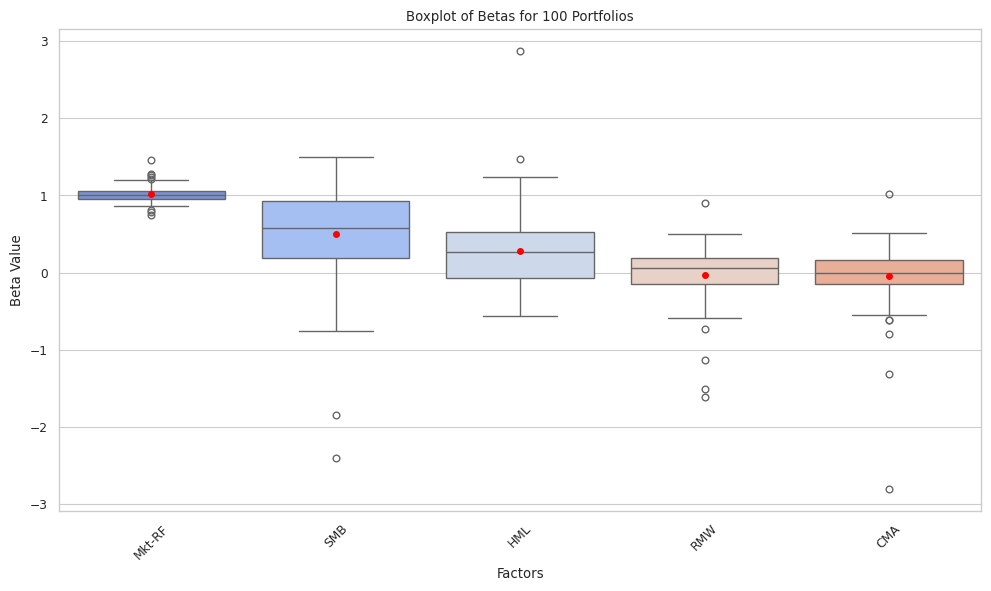

In [29]:
boxplot_betas(regression_results_state_1)

In [30]:
def compute_expected_returns(
    data_fama_french_100_portfolios,
    regression_results_states,
    model_state_means,
    state_probs
):
    factor_cols = ["Alpha", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    n_states = len(regression_results_states)
    result_cols = []
    for i in range(n_states):
        result_cols.extend([
            f"Expected Return State {i+1}",
            f"stdev_state_{i+1}",
            f"sharpe_state_{i+1}"
        ])
    expected_returns = pd.DataFrame(index=data_fama_french_100_portfolios.columns, columns=result_cols)

    for col in data_fama_french_100_portfolios.columns:
        for state, reg_results in enumerate(regression_results_states):
            expected_return = reg_results.loc[col, "Alpha"]
            for i, factor in enumerate(factor_cols[1:]):
                expected_return += reg_results.loc[col, factor] * model_state_means[state, i]
            expected_returns.loc[col, f"Expected Return State {state+1}"] = expected_return

            weighted_std = np.std(data_fama_french_100_portfolios[col] * state_probs[:, state])
            expected_returns.loc[col, f"stdev_state_{state+1}"] = weighted_std

            expected_returns.loc[col, f"sharpe_state_{state+1}"] = expected_return / weighted_std * np.sqrt(12)

    return expected_returns.astype(float).round(4)

In [31]:
expected_returns = compute_expected_returns(
    data_fama_french_100_portfolios,
    [regression_results_state_1, regression_results_state_2],
    model_2_states.means_,
    state_probs_2,
)
expected_returns

,Expected Return State 1,stdev_state_1,sharpe_state_1,Expected Return State 2,stdev_state_2,sharpe_state_2
SMALL LoBM,-0.7095,5.9893,-0.4103,0.1174,5.9222,0.0687
ME1 BM2,-0.4580,5.5099,-0.2879,0.7956,5.7620,0.4783
ME1 BM3,0.6164,5.8247,0.3666,0.7398,5.3935,0.4751
ME1 BM4,-0.1642,4.8546,-0.1172,1.0291,5.2359,0.6809
ME1 BM5,0.3041,4.7406,0.2222,0.8535,4.8856,0.6052
...,...,...,...,...,...,...
ME10 BM6,0.1532,3.4907,0.1521,0.7936,3.5770,0.7685
ME10 BM7,-0.4703,3.5749,-0.4558,0.5491,3.6408,0.5224
ME10 BM8,-7.8433,14.1152,-1.9249,-1.1080,12.1953,-0.3147
ME10 BM9,-8.3590,13.9673,-2.0732,-1.0009,12.5020,-0.2773


Ovo iznad je rezultat koji predstavlja očekivani mjesečni povrat (u %) jednog portfelja kada je unutar stanja 1 ili 2, generalno. Rezultat iznad je treniran na svim podacima. Slijedeći korak koji ćemo napraviti je treniranje HMM i provođenje regresije na periodu do 2010., a out-of-sample ćemo testirati na periodu od 2010. - 2024.

Proces će biti slijedeći: na periodu do 2010. ćemo fittati HMM model s 2 stanja. Naći ćemo model s najboljim LL i njega uzeti za predviđanje vjerojatnosti da smo u stanju 1 ili 2. Iz danog modela izvaditi ćemo prije spomenute vjerojatnosti i means od faktora. Kako bismo izračunali očekivani povrat s faktorskim modelom moramo provesti regresiju. Provesti ćemo ju do istog perioda do kada fittamo HMM model. Izračunati ćemo očekivani povrat svakog od 100 portfelja i uzeti onaj s najboljim Sharpe ratiom. Parametre HMM modela i regresije updateati ćemo svaki mjesec za početak.

In [32]:
def train_test_split(model_parameters_df, data_fama_french_100_portfolios, end_date, start_date="1963-07-01"):
    hmm_train = model_parameters_df.loc[start_date:end_date]
    regression_train = data_fama_french_100_portfolios.loc[start_date:end_date]
    end_date = pd.to_datetime(end_date) + pd.DateOffset(months=1)  # no leakage
    hmm_test = model_parameters_df.loc[end_date:]
    test_returns = data_fama_french_100_portfolios.loc[end_date:]
    return hmm_train, regression_train, hmm_test, test_returns

In [33]:
hmm_train, regression_train, hmm_test, test_returns = train_test_split(
    model_parameters_df,
    data_fama_french_100_portfolios,
    end_date="2010-01-01"
)

In [34]:
aic_train, bic_train, lls_train, convergence_status_train, iterations_train, best_models_train, models_train = evaluate_hmm(
    hmm_train, rs, [2], loop=50
)
hmm_train_model = best_models_train[2]
state_probs_train = hmm_train_model.predict_proba(hmm_train.values, lengths=len(hmm_train))

Model is not converging.  Current: -20479.77339210618 is not greater than -20479.773254701828. Delta is -0.0001374043531541247
Model is not converging.  Current: -19778.96224071624 is not greater than -19778.962240621204. Delta is -9.503492037765682e-08
Model is not converging.  Current: -20540.08900890532 is not greater than -20540.08623969459. Delta is -0.0027692107323673554
Model is not converging.  Current: -19775.92611613525 is not greater than -19775.92611609648. Delta is -3.8769940147176385e-08


Convergence Status:  [True]
Iterations:  [45]


In [35]:
run_model_analysis(
    hmm_train_model, hmm_train, dirname="state_analysis_train_model", fred_recessions=fred_recessions, state_probs=state_probs_train
)

('Successfully saved figures to directory:',
 'figures/state_analysis_train_model/2_states/')

In [37]:
%%capture --no-display

index = pd.MultiIndex.from_product(
    [test_returns.index, test_returns.columns], names=["Date", "Portfolio"]
)
out_of_sample_comparison_df = pd.DataFrame(index=index, columns=["Expected Return", "Real Return", "Stdev", "Sharpe"])
termination_date = test_returns.index[-1]

while test_returns.index[0] < termination_date:
    regression_results_state_1, regression_results_state_2 = run_weighted_ff_regressions(
        regression_train,
        hmm_train,
        state_probs_train
    )
    expected_returns = compute_expected_returns(
        regression_train,
        [regression_results_state_1, regression_results_state_2],
        hmm_train_model.means_,
        state_probs_train
    )
    
    current_date = test_returns.index[0]
    current_state_probs = state_probs_train[-1]
    for col in test_returns.columns:
        mean1 = expected_returns.loc[col, "Expected Return State 1"]
        mean2 = expected_returns.loc[col, "Expected Return State 2"]
        std1 = expected_returns.loc[col, "stdev_state_1"]
        std2 = expected_returns.loc[col, "stdev_state_2"]
        p1, p2 = current_state_probs[0], current_state_probs[1]
        expected_return = mean1 * p1 + mean2 * p2
        
        var = p1 * (std1 **2 + (mean1 - expected_return)**2) + p2 * (std2 **2 + (mean2 - expected_return)**2)
        stdev = np.sqrt(var)
        sharpe = expected_return / stdev * np.sqrt(12)
        out_of_sample_comparison_df.loc[(current_date, col), "Expected Return"] = expected_return
        out_of_sample_comparison_df.loc[(current_date, col), "Real Return"] = test_returns.loc[current_date, col]
        out_of_sample_comparison_df.loc[(current_date, col), "Stdev"] = stdev
        out_of_sample_comparison_df.loc[(current_date, col), "Sharpe"] = sharpe
    
    hmm_train = pd.concat([hmm_train, hmm_test.iloc[0:1]])
    regression_train = pd.concat([regression_train, test_returns.iloc[0:1]])
    test_returns = test_returns.iloc[1:]
    hmm_test = hmm_test.iloc[1:]
    
    # refit the model and redo the regression
    aic_train, bic_train, lls_train, convergence_status_train, iterations_train, best_models_train, models_train = evaluate_hmm(
        hmm_train, rs, [2], loop=50
    )
    hmm_train_model = best_models_train[2]
    state_probs_train = hmm_train_model.predict_proba(hmm_train.values, lengths=len(hmm_train))


In [38]:
out_of_sample_comparison_df

Expected Return Real Return     Stdev    Sharpe
Date       Portfolio                                                 
2010-02-01 SMALL LoBM        0.079363      6.6832  6.030377  0.045589
           ME1 BM2           0.668733      0.9922  5.700973  0.406345
           ME1 BM3           0.728205      0.8251   5.42382  0.465092
           ME1 BM4           1.084371      2.3392  5.237688  0.717181
           ME1 BM5           0.884811       3.312  4.838458  0.633482
...                               ...         ...       ...       ...
2024-12-01 ME10 BM6               NaN         NaN       NaN       NaN
           ME10 BM7               NaN         NaN       NaN       NaN
           ME10 BM8               NaN         NaN       NaN       NaN
           ME10 BM9               NaN         NaN       NaN       NaN
           BIG HiBM               NaN         NaN       NaN       NaN

[17900 rows x 4 columns]

In [39]:
out_of_sample_comparison_df = out_of_sample_comparison_df.astype(float).round(4)

In [40]:
y_baseline = pd.DataFrame(index=out_of_sample_comparison_df.index, columns=["Baseline"])
for date, port in out_of_sample_comparison_df.index:
    y_baseline.loc[(date, port), "Baseline"] = data_fama_french_100_portfolios.loc["1963-07-01":date, port].mean()

y_baseline

Baseline
Date       Portfolio            
2010-02-01 SMALL LoBM   0.388306
           ME1 BM2      0.840974
           ME1 BM3      1.101449
           ME1 BM4      1.351487
           ME1 BM5      1.219312
...                          ...
2024-12-01 ME10 BM6     1.016586
           ME10 BM7      0.68875
           ME10 BM8    -2.224999
           ME10 BM9    -2.254801
           BIG HiBM   -12.801902

[17900 rows x 1 columns]

In [41]:
def r_squared(y_true, y_pred, y_baseline):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_baseline)) ** 2)
    return 1 - (ss_res / ss_tot)

In [42]:
r_squared(
    out_of_sample_comparison_df["Real Return"],
    out_of_sample_comparison_df["Expected Return"],
    y_baseline["Baseline"]
)

np.float64(-0.16968171472395444)

In [43]:
# pick best sharpe ratio portfolio for each month
def pick_best_sharpe_portfolio(out_of_sample_comparison_df):
    best_sharpe = out_of_sample_comparison_df.groupby(level=0).apply(
        lambda x: x.loc[x["Sharpe"].idxmax()]
    )
    return best_sharpe

best_sharpe = pick_best_sharpe_portfolio(out_of_sample_comparison_df.dropna())
best_sharpe

,Expected Return,Real Return,Stdev,Sharpe
Date,,,,
2010-02-01,1.3367,5.9206,4.2868,1.0802
2010-03-01,1.4495,9.9517,4.2846,1.1719
2010-04-01,1.4699,6.1442,4.2883,1.1874
2010-05-01,1.4711,-10.2253,4.2896,1.1880
2010-06-01,1.4562,-10.3181,4.3300,1.1650
...,...,...,...,...
2024-07-01,1.8312,6.4162,4.7629,1.3318
2024-08-01,1.7419,-4.6879,4.7730,1.2642
2024-09-01,1.2720,-1.3332,4.4056,1.0001


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


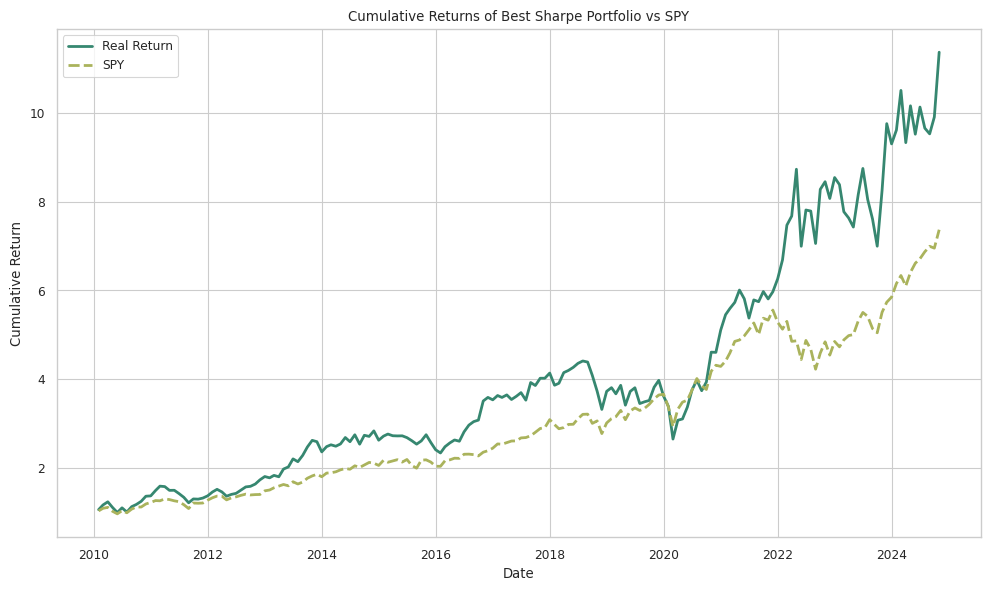

In [44]:
# Compare to SPY
spy_data = download(
    "SPY",
    start="2010-01-01",
    end="2024-12-01",
    interval="1mo",
)
spy_data = spy_data[["Close"]]
spy_data_returns = spy_data.pct_change().dropna()
callable_df = pd.concat(
    [best_sharpe["Real Return"]/100, spy_data_returns["Close"]], axis=1
)

plot_cumulative_returns(
    callable_df,
    title="Cumulative Returns of Best Sharpe Portfolio vs SPY",
)